just want more ram...

In [0]:
# a = []
# while(1):
#     a.append('1')

## Setting & Import packages

In [2]:
!pip install catboost

     |████████████████████████████████| 64.4MB 48kB/s 


In [3]:
!nvidia-smi

Wed Apr 15 00:50:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
import os
import gc
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor, Pool

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
drive.mount('/melissakou', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /melissakou


In [0]:
os.chdir('/melissakou/My Drive/Colab Notebooks/m5')

In [0]:
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')

In [0]:
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')

In [0]:
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')

## Preprocessing

### calendar

In [11]:
#calendar = calendar.drop(columns = ['date', 'weekday', 'event_name_2', 'event_type_2'])
calendar[['event_name_1', 'event_type_1']] = calendar[['event_name_1', 'event_type_1']].fillna('none')
calendar['is_weekend'] = (calendar['wday'] == 6) | (calendar['wday'] == 7)
calendar['is_month_start'] = calendar['date'].str[-2:] == '01'
calendar['is_month_end'] = (calendar['date'].str[-2:] == '31') |(calendar['date'].str[-2:] == '30')
calendar['d'] = calendar.d.str[2:].astype('int')
calendar = calendar.drop(columns = ['date', 'weekday', 'event_name_2', 'event_type_2'])
calendar

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_weekend,is_month_start,is_month_end
0,11101,1,1,2011,1,none,none,0,0,0,False,False,False
1,11101,2,1,2011,2,none,none,0,0,0,False,False,True
2,11101,3,1,2011,3,none,none,0,0,0,False,False,True
3,11101,4,2,2011,4,none,none,1,1,0,False,True,False
4,11101,5,2,2011,5,none,none,1,0,1,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,11620,5,6,2016,1965,none,none,0,1,1,False,False,False
1965,11620,6,6,2016,1966,none,none,0,0,0,True,False,False
1966,11620,7,6,2016,1967,none,none,0,0,0,True,False,False
1967,11621,1,6,2016,1968,none,none,0,0,0,False,False,False


### prices

In [0]:
gr = prices.groupby(["store_id", "item_id"])["sell_price"]

In [13]:
gr = prices.groupby(["store_id", "item_id"])["sell_price"]
prices['price_pct_change'] = (prices['sell_price'] - gr.transform(lambda x: x.shift(7))) / gr.transform(lambda x: x.shift(7))
prices['price_discount'] = prices['sell_price'] / gr.cummax()
prices['price_roll_std_7'] = gr.transform(lambda x: x.rolling(30).std())
del gr
gc.collect()

prices

0

,store_id,item_id,wm_yr_wk,sell_price,price_pct_change,price_discount,price_roll_std_7
0,CA_1,HOBBIES_1_001,11325,9.58,NaN,1.000000,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,NaN,1.000000,NaN
2,CA_1,HOBBIES_1_001,11327,8.26,NaN,0.862213,NaN
3,CA_1,HOBBIES_1_001,11328,8.26,NaN,0.862213,NaN
4,CA_1,HOBBIES_1_001,11329,8.26,NaN,0.862213,NaN
...,...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00,0.0,1.000000,0.0
6841117,WI_3,FOODS_3_827,11618,1.00,0.0,1.000000,0.0
6841118,WI_3,FOODS_3_827,11619,1.00,0.0,1.000000,0.0
6841119,WI_3,FOODS_3_827,11620,1.00,0.0,1.000000,0.0


### sales

In [0]:
drop = 1000
sales = sales.drop(columns = ["d_" + str(i+1) for i in range(drop-1)])
sales = sales.reindex(columns = sales.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
sales.id = sales.id.str.replace('_validation', '')

In [15]:
sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                   var_name='d', value_name='demand')
gc.collect()

24

In [16]:
gr = sales.groupby(['id'])['demand']
print('Creating Features:')
print('demand_lag_28')
sales['demand_lag_28'] = gr.transform(lambda x: x.shift(28))

print('demand_lag_35')
sales['demand_lag_35'] = gr.transform(lambda x: x.shift(35))

print('demand_lag_365')
sales['demand_lag_365'] = gr.transform(lambda x: x.shift(365))

print('demand_lag_365_roll_mean')
sales['demand_lag_365_roll_mean'] = gr.transform(lambda x: x.shift(365).rolling(5, center = True).mean())
#sales['demand_lag_42'] = gr.transform(lambda x: x.shift(42))
#sales['demand_lag_49'] = gr.transform(lambda x: x.shift(49))

print('roll_mean_7')
sales['roll_mean_7'] = gr.transform(lambda x: x.shift(28).rolling(7).mean())

print('roll_mean_30')
sales['roll_mean_30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())

print('roll_mean_60')
sales['roll_mean_60'] = gr.transform(lambda x: x.shift(28).rolling(60).mean())

print('roll_mean_90')
sales['roll_mean_90'] = gr.transform(lambda x: x.shift(28).rolling(90).mean())

print('roll_mean_180')
sales['roll_mean_180'] = gr.transform(lambda x: x.shift(28).rolling(180).mean())

print('roll_std_7')
sales['roll_std_7'] = gr.transform(lambda x: x.shift(28).rolling(7).std())

print('roll_std_30')
sales['roll_std_30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())

del gr
gc.collect()

sales['d'] = sales.d.str[2:].astype('int')
gc.collect()
# sales = sales[(sales.d >= 1914) | (pd.notna(sales.demand_lag_365_roll_mean))]
# sales.head()
# sales.shape
# gc.collect()

Creating Features:
demand_lag_28
demand_lag_35
demand_lag_365
demand_lag_365_roll_mean
roll_mean_7
roll_mean_30
roll_mean_60
roll_mean_90
roll_mean_180
roll_std_7
roll_std_30


0

12

### merge data

In [17]:
sales = pd.merge(sales, calendar, how = 'left', on = 'd')
del calendar
gc.collect()
sales = pd.merge(sales, prices, how = "left", on = ["store_id", "item_id", "wm_yr_wk"])
del prices
gc.collect()
sales.drop(columns = ["wm_yr_wk"])
gc.collect()

0

0

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_365,demand_lag_365_roll_mean,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_weekend,is_month_start,is_month_end,sell_price,price_pct_change,price_discount,price_roll_std_7
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10,2013,none,none,0,0,0,True,False,False,8.26,0.0,0.862213,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10,2013,none,none,0,0,0,True,False,False,3.97,0.0,1.000000,0.000000e+00
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10,2013,none,none,0,0,0,True,False,False,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10,2013,none,none,0,0,0,True,False,False,4.64,0.0,1.000000,4.746564e-08
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10,2013,none,none,0,0,0,True,False,False,3.08,0.0,1.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,2.98,0.0,1.000000,1.976889e-01
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,2.48,0.0,0.925373,2.391710e-01
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,3.98,0.0,0.908676,2.749728e-08
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,1.28,0.0,1.000000,0.000000e+00


11

In [0]:
sales['sales'] = sales['demand'] * sales['sell_price']
sales['weight'] = sales.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).sum())

In [19]:
sales = sales[(sales.d >= 1914) | (pd.notna(sales.demand_lag_365_roll_mean))]
sales.head()
sales.shape
gc.collect()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_365,demand_lag_365_roll_mean,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_weekend,is_month_start,is_month_end,sell_price,price_pct_change,price_discount,price_roll_std_7,sales,weight
11189830,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1367,1.0,1.0,0.0,2.0,1.0,0.428571,0.700000,0.566667,0.544444,0.483333,0.534522,0.700000,11439,2,10,2014,none,none,0,0,0,False,False,False,8.26,0.0,0.862213,2.697012e-08,8.26,1.321600e+02
11189831,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1367,0.0,0.0,0.0,1.0,0.2,0.000000,0.166667,0.266667,0.322222,0.344444,0.000000,0.166667,11439,2,10,2014,none,none,0,0,0,False,False,False,3.97,0.0,1.000000,0.000000e+00,0.00,4.367000e+01
11189832,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1367,0.0,2.0,0.0,0.0,0.0,0.428571,0.300000,0.183333,0.166667,0.188889,0.786796,0.300000,11439,2,10,2014,none,none,0,0,0,False,False,False,2.97,0.0,1.000000,0.000000e+00,0.00,-1.687539e-14
11189833,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1367,6.0,0.0,0.0,8.0,3.6,1.000000,2.100000,2.250000,2.344444,2.400000,1.290994,2.100000,11439,2,10,2014,none,none,0,0,0,False,False,False,4.64,0.0,1.000000,4.746564e-08,27.84,2.134400e+02
11189834,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1367,1.0,0.0,3.0,1.0,0.6,0.714286,0.766667,0.750000,0.777778,0.800000,0.487950,0.766667,11439,2,10,2014,none,none,0,0,0,False,False,False,2.88,0.0,0.935065,1.017095e-01,2.88,1.180800e+02


(18385470, 37)

11

In [20]:
gc.collect()

0

In [0]:
# v = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
# sales[v] = OrdinalEncoder().fit_transform(sales[v]).astype('int')

# del v
# gc.collect()

# sales.head()

In [0]:
# sales.to_csv('sales.csv', index = False)

In [0]:
# sales = pd.read_csv('sales.csv')
# sales

## Model

### test data preparation

In [24]:
test = sales[sales.d >= 1914]
test = test.assign(id = test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F = "F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_365,demand_lag_365_roll_mean,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_weekend,is_month_start,is_month_end,sell_price,price_pct_change,price_discount,price_roll_std_7,sales,weight,F
27867860,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,1.0,0.0,0.6,1.142857,1.033333,0.983333,0.944444,0.772222,0.690066,1.033333,11613,3,4,2016,none,none,0,0,0,False,False,False,8.38,0.014528,0.874739,3.661543e-02,NaN,NaN,F1
27867861,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,0.0,0.0,0.2,0.714286,0.333333,0.250000,0.211111,0.377778,0.487950,0.333333,11613,3,4,2016,none,none,0,0,0,False,False,False,3.97,0.000000,1.000000,0.000000e+00,NaN,NaN,F1
27867862,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,0.0,0.0,0.0,0.2,0.285714,0.500000,0.416667,0.344444,0.633333,0.487950,0.500000,11613,3,4,2016,none,none,0,0,0,False,False,False,2.97,0.000000,1.000000,0.000000e+00,NaN,NaN,F1
27867863,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,0.0,4.0,3.0,2.4,3.000000,1.966667,2.100000,2.033333,1.900000,2.708013,1.966667,11613,3,4,2016,none,none,0,0,0,False,False,False,4.64,0.000000,1.000000,4.746564e-08,NaN,NaN,F1
27867864,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1914,NaN,1.0,2.0,0.0,1.0,0.714286,1.100000,1.133333,0.966667,1.172222,1.112697,1.100000,11613,3,4,2016,none,none,0,0,0,False,False,False,2.88,0.000000,0.935065,0.000000e+00,NaN,NaN,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29575295,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,2.98,0.000000,1.000000,1.976889e-01,NaN,NaN,F28
29575296,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,2.48,0.000000,0.925373,2.391710e-01,NaN,NaN,F28
29575297,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,3.98,0.000000,0.908676,2.749728e-08,NaN,NaN,F28
29575298,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11621,2,6,2016,NBAFinalsEnd,Sporting,0,0,0,False,False,False,1.28,0.000000,1.000000,0.000000e+00,NaN,NaN,F28


### train & validation data for LGBM

In [25]:
sales = sales[sales.d < 1914]
gc.collect()

11

In [26]:
gc.collect()

0

In [27]:
x = list(sales.columns)
for v in ['id', 'd', 'demand', 'wm_yr_wk']:
    x.remove(v)
x
gc.collect()

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'demand_lag_28',
 'demand_lag_35',
 'demand_lag_365',
 'demand_lag_365_roll_mean',
 'roll_mean_7',
 'roll_mean_30',
 'roll_mean_60',
 'roll_mean_90',
 'roll_mean_180',
 'roll_std_7',
 'roll_std_30',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'sell_price',
 'price_pct_change',
 'price_discount',
 'price_roll_std_7',
 'sales',
 'weight']

22

In [0]:
val_ind = sales.d >= 1914 - 28
train_X = sales[~val_ind][x]
train_Y = sales[~val_ind]['demand']
val_X = sales[val_ind][x]
val_Y = sales[val_ind]['demand']

In [29]:
val_sub = sales[val_ind]
val_sub = val_sub.assign(F = "F" + (val_sub.d - 1885).astype("str"))
val_sub
gc.collect()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag_28,demand_lag_35,demand_lag_365,demand_lag_365_roll_mean,roll_mean_7,roll_mean_30,roll_mean_60,roll_mean_90,roll_mean_180,roll_std_7,roll_std_30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_weekend,is_month_start,is_month_end,sell_price,price_pct_change,price_discount,price_roll_std_7,sales,weight,F
27014140,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,0.0,4.0,2.0,1.4,1.142857,1.000000,0.883333,0.833333,0.711111,1.463850e+00,1.000000,11609,3,3,2016,none,none,0,0,0,False,False,False,8.26,0.00,0.862213,2.697012e-08,8.26,239.54,F1
27014141,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,0.0,0.0,0.0,0.0,0.142857,0.166667,0.150000,0.400000,0.366667,3.779645e-01,0.166667,11609,3,3,2016,none,none,0,0,0,False,False,False,3.97,0.00,1.000000,0.000000e+00,3.97,39.70,F1
27014142,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1886,0.0,0.0,0.0,0.0,0.4,0.000000,0.300000,0.250000,0.655556,0.661111,5.071505e-08,0.300000,11609,3,3,2016,none,none,0,0,0,False,False,False,2.97,0.00,1.000000,0.000000e+00,0.00,44.55,F1
27014143,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1886,0.0,0.0,2.0,0.0,2.8,1.857143,2.200000,2.066667,1.922222,1.883333,2.115701e+00,2.200000,11609,3,3,2016,none,none,0,0,0,False,False,False,4.64,0.00,1.000000,4.746564e-08,0.00,245.92,F1
27014144,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1886,1.0,1.0,0.0,1.0,0.6,1.000000,1.133333,0.916667,1.100000,1.188889,1.000000e+00,1.133333,11609,3,3,2016,none,none,0,0,0,False,False,False,2.88,0.00,0.935065,0.000000e+00,2.88,89.28,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27867855,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1913,1.0,0.0,0.0,0.0,0.4,0.000000,0.266667,0.500000,0.611111,0.677778,3.547186e-08,0.266667,11613,2,4,2016,none,none,0,0,0,False,False,False,2.98,0.00,1.000000,2.054432e-01,2.98,17.88,F28
27867856,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1913,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,11613,2,4,2016,none,none,0,0,0,False,False,False,2.48,0.24,0.925373,1.659580e-01,0.00,22.32,F28
27867857,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1913,0.0,1.0,0.0,0.0,0.6,0.714286,1.233333,0.933333,0.900000,0.638889,9.511897e-01,1.233333,11613,2,4,2016,none,none,0,0,0,False,False,False,3.98,0.00,0.908676,2.749728e-08,0.00,99.50,F28
27867858,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3.0,4.0,1.0,0.0,0.0,1.571429,1.166667,1.100000,1.188889,1.405556,1.272418e+00,1.166667,11613,2,4,2016,none,none,0,0,0,False,False,False,1.28,0.00,1.000000,0.000000e+00,3.84,33.28,F28


0

In [30]:
del val_ind, sales
gc.collect()

0

### model training

In [0]:
cat_fea = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'wday', 'month', 'year', 'event_name_1', 'event_type_1',
           'is_weekend', 'is_month_start', 'is_month_end']

#cat_fea = ['item_id', 'store_id', 'wday', 'month', 'year', 'event_name_1']

In [32]:
gc.collect()

0

In [0]:
demand_mean = train_X['roll_mean_180']
price = train_X['sell_price'].fillna(0)

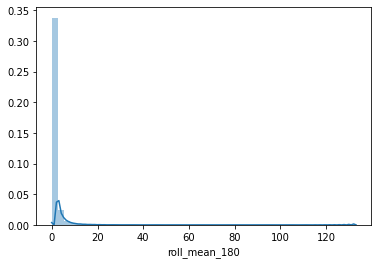

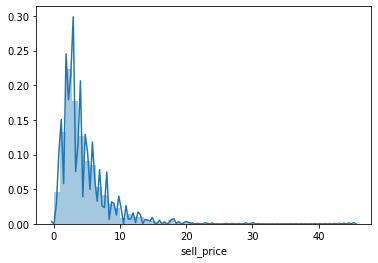

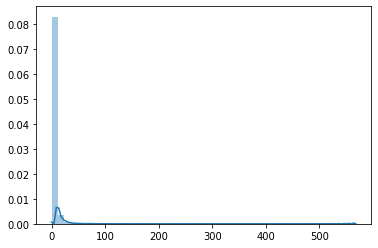

In [34]:
sns.distplot(demand_mean)
plt.show()
plt.close()

sns.distplot(price)
plt.show()
plt.close()

sns.distplot(demand_mean * price)

weight = (demand_mean * price)

In [35]:
min(demand_mean)

0.0

In [0]:
weight = train_X['weight']

In [0]:
weight = [max(0, x) for x in weight]

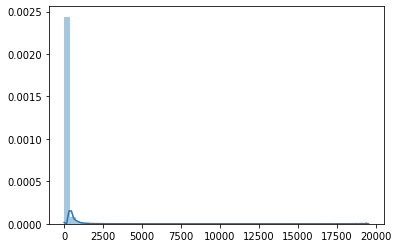

In [43]:
sns.distplot(weight)

In [0]:
train_X = train_X.drop(columns = ['weight', 'sales'])
val_X = val_X.drop(columns = ['weight', 'sales'])

In [45]:
train_pool = Pool(train_X, train_Y, cat_features = cat_fea, weight = weight)
val_pool = Pool(val_X, val_Y, cat_features = cat_fea)

del train_X, train_Y
gc.collect()

11688

In [46]:
model = CatBoostRegressor(iterations = 2000,
                          learning_rate = 0.08,
                          early_stopping_rounds = 400,
                          depth = 8,
                          # max_leaves = 36,
                          min_data_in_leaf = 20,
                          one_hot_max_size = 128,
                          border_count = 255,
                          feature_border_type = 'Median',
                          #max_ctr_complexity = 2,
                          loss_function = 'RMSE',
                          eval_metric = 'RMSE',
                          task_type = 'GPU',
                          has_time = True,
                          #grow_policy = 'Lossguide',
                          verbose = 50)
model.fit(X = train_pool, eval_set = val_pool)

0:	learn: 11.7489662	test: 5.2807665	best: 5.2807665 (0)	total: 301ms	remaining: 10m 1s
50:	learn: 5.7747411	test: 2.3307121	best: 2.3307121 (50)	total: 14.4s	remaining: 9m 9s
100:	learn: 5.4441150	test: 2.3100902	best: 2.3100902 (100)	total: 28.6s	remaining: 8m 58s
150:	learn: 5.2475119	test: 2.2927731	best: 2.2926750 (144)	total: 42.7s	remaining: 8m 42s


KeyboardInterrupt: ignored

In [0]:
# model.save_model('catboost.cbm')

In [0]:
# model = CatBoostRegressor()
# model.load_model('catboost.cbm')

In [0]:
#del train_pool, val_pool
gc.collect()

0

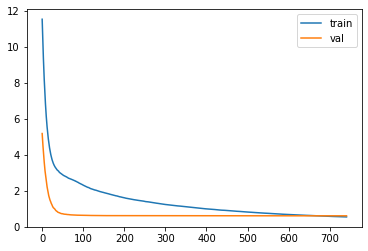

In [49]:
plt.plot(model.evals_result_['learn']['RMSE'], label = 'train')
plt.plot(model.evals_result_['validation']['RMSE'], label = 'val')
plt.legend()

<Figure size 720x432 with 0 Axes>

120

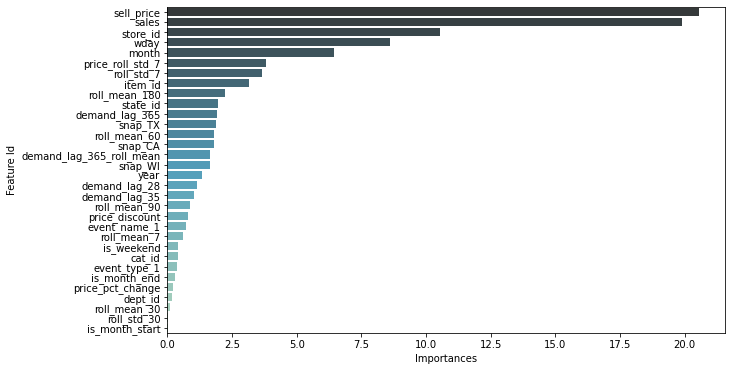

In [50]:
feature_imp = model.get_feature_importance(prettified = True)
plt.figure(figsize = (10, 6))
sns.barplot(y = feature_imp['Feature Id'], x = feature_imp['Importances'], palette = 'GnBu_d')
del feature_imp
gc.collect()

<Figure size 360x360 with 0 Axes>

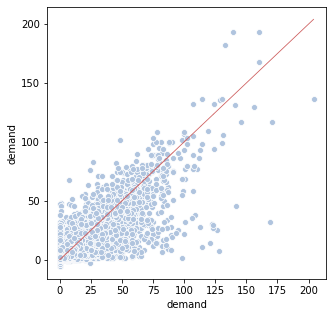

In [0]:
plt.figure(figsize = (5, 5))
#sns.scatterplot(val_Y, [max(0, x) for x in model.get_test_eval()], color = 'lightsteelblue')
sns.scatterplot(val_Y, model.get_test_eval(), color = 'lightsteelblue')
sns.lineplot(val_Y, val_Y, color = 'indianred', lw = 0.8)

In [0]:
# train_pred = model.predict()

In [0]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression(fit_intercept=True)

# model.fit(train_pred.reshape(-1, 1), train.get_label())

In [0]:
# model.coef_
# model.intercept_

In [0]:
# plt.figure(figsize = (5, 5))
# plt.scatter(train.get_label(), train_pred * 1.03)
# plt.plot(train.get_label(), train.get_label(), '-', color = 'red')

In [0]:
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [0]:
submission = pd.read_csv('m5-forecasting-accuracy/sample_submission.csv')
F = submission.columns
idx = submission.id
del submission
gc.collect()

val_sub['demand'] = [max(0, x) for x in model.get_test_eval()]
val_pred = val_sub.pivot(index = 'id', columns = 'F', values = 'demand').reset_index()[F]
val_pred['id'] = (val_pred['id'] + '_validation').astype('str')
val_pred['id'] = pd.Categorical(val_pred['id'], categories = idx)
val_pred = val_pred.sort_values(by = 'id')

gc.collect()
val_pred

8020

0

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
14370,HOBBIES_1_001_CA_1_validation,0.875542,0.698002,0.581917,0.656727,0.866933,1.097327,0.901398,0.614667,0.540372,0.524502,0.645761,0.898104,1.131916,1.135185,0.621653,0.712549,0.553784,0.780578,1.116502,0.926544,1.253845,0.826327,0.956204,0.884872,1.021956,1.154557,1.178532,1.368858
14380,HOBBIES_1_002_CA_1_validation,0.357787,0.276685,0.345148,0.352670,0.395900,0.479769,0.443532,0.385557,0.231384,0.242136,0.353889,0.420666,0.638375,0.563302,0.230089,0.132097,0.218015,0.165208,0.284689,0.482105,0.427778,0.256916,0.176487,0.209529,0.253105,0.397690,0.556882,0.524180
14390,HOBBIES_1_003_CA_1_validation,0.211944,0.128188,0.229498,0.217413,0.319533,0.686773,0.514178,0.406586,0.390691,0.308845,0.416483,0.496388,0.751261,0.553797,0.219572,0.123273,0.168836,0.144177,0.285296,0.461391,0.460739,0.227880,0.138773,0.173725,0.165060,0.300989,0.472912,0.447511
14400,HOBBIES_1_004_CA_1_validation,1.878678,1.770124,1.706687,1.700342,2.058841,2.339311,3.179322,2.114672,1.733408,1.784373,1.800201,2.072040,2.577154,2.924849,2.058917,1.548177,1.621710,1.568717,2.151542,2.579510,2.794281,2.193377,1.791625,1.866934,2.086621,2.194782,2.960058,3.443967
14410,HOBBIES_1_005_CA_1_validation,0.999851,0.915182,1.000836,0.999746,1.093101,1.284103,1.387888,1.116829,0.832240,0.825036,0.878055,1.147951,1.392366,1.429251,1.024018,0.795481,0.870678,0.721550,1.145842,1.505541,1.685243,1.217647,1.090024,1.011201,0.925431,1.121224,1.296857,1.418079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14329,FOODS_3_823_WI_3_validation,0.490103,0.656511,0.471093,0.518921,0.740783,1.162496,1.234603,0.581844,1.020939,0.915201,0.724720,0.851088,1.266593,0.933863,0.891100,1.082545,0.830715,0.826806,1.052178,1.003129,1.016969,0.520436,0.683625,0.606760,0.563823,0.662873,0.584116,0.609974
14339,FOODS_3_824_WI_3_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121337,0.000000,0.203774,0.593821,0.266305,0.051361,0.507397,0.000000,0.386659,0.329502,0.534587,0.207417,0.585988,0.160499,0.250644,0.075211,0.059214,0.445681,0.138524,0.211781,0.329036,0.355269
14349,FOODS_3_825_WI_3_validation,0.466960,0.544890,0.582312,0.611466,0.917889,1.098484,1.208094,0.799501,1.004484,1.009535,1.041756,1.118907,1.265564,1.006804,0.812886,1.062254,0.763904,0.827114,1.071237,0.913524,0.909938,0.691797,0.662148,0.574114,0.578690,0.773456,0.802389,0.856929
14359,FOODS_3_826_WI_3_validation,0.780228,0.791661,0.854693,0.979419,1.020211,1.340111,1.395694,0.888902,0.950680,0.894762,0.890619,1.019125,1.287697,1.250267,0.796908,1.033259,0.795958,0.912690,1.211634,1.215511,1.295456,0.695710,0.865532,0.818665,0.821136,1.073632,1.239524,1.571681


In [0]:
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')
train_fold_df = sales.iloc[:, :-28]
valid_fold_df = sales.iloc[:, -28:].copy()

del sales
gc.collect()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

0

In [0]:
e.score(np.array(val_pred.iloc[:, 1:]))

0.565803421571066

In [0]:
del e
gc.collect()

36

In [0]:
gc.collect()

0

## Predict for d_1914 ~ d_1941

In [0]:
pred = model.predict(test[x])
test['demand'] = [max(0,x) for x in pred]

In [0]:
submission = test.pivot(index = 'id', columns = 'F', values = 'demand').reset_index()[F]
submission

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.337897,1.090347,1.121303,1.127318,1.271381,1.375864,1.190804,1.305959,1.208445,0.797924,0.908076,0.904017,1.017691,0.882476,0.843536,0.759464,0.726559,0.816458,0.914181,1.134415,0.964304,0.954071,0.789581,0.791968,0.878584,1.000643,1.092918,0.886554
1,FOODS_1_001_CA_1_validation,0.839665,0.770784,0.780101,0.791183,1.128446,1.083027,0.858379,0.984722,0.761731,1.033603,0.863642,1.074148,1.201797,0.802468,0.940096,0.779553,0.660831,0.725260,0.831370,1.014403,0.922726,1.009961,0.738513,0.774253,0.789483,0.946088,1.113584,0.997713
2,FOODS_1_001_CA_2_evaluation,0.808648,0.669438,0.748583,0.919486,0.775909,0.868766,0.984262,0.817581,0.678971,0.663388,0.678000,0.835379,0.922500,0.954400,0.739950,0.701013,0.728703,0.804159,0.869913,1.125296,1.133433,0.893267,0.766083,0.843953,0.861239,0.958682,1.043316,0.919607
3,FOODS_1_001_CA_2_validation,0.902650,0.822685,0.845205,0.907918,1.011164,1.146135,0.880769,0.661350,0.713165,0.861692,0.705976,0.916162,1.230700,0.681475,0.724979,0.788072,0.780855,0.798905,0.989652,0.917688,1.881982,1.110035,1.071920,1.099668,1.237244,1.283502,1.354266,2.175286
4,FOODS_1_001_CA_3_evaluation,0.943862,0.835963,0.833507,0.807255,0.834358,1.009031,0.984402,1.166271,0.830570,0.760202,0.970083,0.966747,1.073854,1.131466,1.151329,0.934930,0.893879,0.970797,1.027757,1.290056,1.204610,1.137098,0.996237,0.896492,1.091518,1.082299,1.215911,1.151034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,0.033141,0.000000,0.041775,0.059562,0.110584,0.161589,0.077024,0.000000,0.000000,0.070067,0.049896,0.040827,0.244487,0.000000,0.023907,0.020753,0.085637,0.137997,0.217102,0.252492,0.318168,0.090018,0.069385,0.102802,0.122545,0.150881,0.151022,0.143048
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,HOUSEHOLD_2_516_WI_2_validation,0.016020,0.000000,0.052904,0.044794,0.098982,0.000000,0.000000,0.000000,0.000000,0.093908,0.026759,0.018382,0.117895,0.000000,0.000000,0.014658,0.061909,0.090331,0.132260,0.000000,0.080379,0.000000,0.000000,0.015011,0.104996,0.141145,0.081326,0.049297
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
submission.to_csv('submission_0414_2.csv', index = False)